In [1]:
# IO: do this:
#source activate fullenv
#python -m ipykernel install --user --name fullenv --display-name "fullenv"
# also see this https://anbasile.github.io/posts/2017-06-25-jupyter-venv/
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
bg_file_list = glob.glob("/Users/inesochoa/PhysicsWorkdir/snowmassWorkDir/ILCAnomalies/processed_lhe*_background.txt")
signal_file_list = glob.glob("//Users/inesochoa/PhysicsWorkdir/snowmassWorkDir/ILCAnomalies/processed_lhe*signal.txt")

# Using DNN with Nsubjettiness variables from EnergyFlow package

## Data parsing, plotting, ...

In [3]:
#From Ben, function to parse files:
def parse_file(file_object):
    all_records = []
    mymeasuredenergy = []

    count = 0
    for line in file_object:

        metadata = line.split("J")[0]
        eventinfo = line.split("J")[1]
        jets = eventinfo.split("P")[0]
        particles = eventinfo.split("P")[1]

        this_record = {}
        this_record['label'] = count
        count += 1
        eventweight = float(metadata.split()[0])
        this_record['eventweight'] = eventweight #this is the event "weight".  Let's ignoreit for now (we will need it later).
        njets = int(len(jets.split())/11) #number of "jets"

        nparticles  = int(len(particles.split())/5) #number of particles

        #True collision quantities
        this_record['truthcenterofmassenergy'] = float(metadata.split()[1]) #true total energy - should be delta function at 1000 GeV
        this_record['truthsqrtshat'] = float(metadata.split()[2]) #energy available for making new particles (electron energy - photon)
        this_record['truthphotonpT'] = float(metadata.split()[3]) #photon momentum |p| in units of GeV
        this_record['truthphotoneta'] = float(metadata.split()[4]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        this_record['truthphotonphi'] = float(metadata.split()[5]) #photon azimuthal angle

        #Measured collision quantities
        measuredcenterofmassenergy  = float(metadata.split()[6]) #true measured energy - should be noisy version of truthcenterofmassenergy
        this_record['measuredcenterofmassenergy'] = measuredcenterofmassenergy
        this_record['measuredsqrtshat'] = float(metadata.split()[7]) #energy available for making new particles (electron energy - photon)
        this_record['measuredphotonpT'] = float(metadata.split()[8]) #photon momentum |p| in units of GeV
        this_record['measuredphotoneta'] = float(metadata.split()[9]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        this_record['measuredphotonphi'] = float(metadata.split()[10]) #photon azimuthal angle
        this_record['metadata'] = metadata.split()

        mymeasuredenergy+=[measuredcenterofmassenergy]

        this_record['njets'] = njets
        jets = jets.split()
        jets_vec = []
        for i in range(njets):
            jet = np.zeros(11)
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - mass (units of GeV/c^2)
            # - bit encoding of the jet "flavor" (not totally sure what the bit means, but will look it up)
            # - 0th angular moment of jet radiation
            # - 1th angular moment of jet radiation
            # - 2th angular moment of jet radiation
            # - 3th angular moment of jet radiation
            # - 4th angular moment of jet radiation
            jet = jets[i*11:i*11+11]
            jets_vec+=[jet]

        this_record['jets']=jets_vec

        this_record['nparticles'] = nparticles

        particles = particles.split()
        particles_vec = []
        for i in range(nparticles):
            particle = np.zeros(5)
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - particle identifier (https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf)
            particle = particles[i*5:i*5+5]
            particles_vec+=[particle]
            #print(particles[i*5],particles[i*5+1],particles[i*5+2],particles[i*5+3],particles[i*5+4])
        this_record['particles'] = particles_vec

        
        all_records.append(this_record)
    return all_records

In [4]:
bg_records = []
for filename in bg_file_list:
    file = open(filename)
    bg_records += parse_file(file)
sig_records = []
for filename in signal_file_list:
    file = open(filename)
    sig_records += parse_file(file)

In [5]:
len(bg_records),len(sig_records)

(79999, 100000)

In [6]:
for i in sig_records:
    i['from_anomaly_data'] = True
for i in bg_records:
    i['from_anomaly_data'] = False

In [7]:
all_records = sig_records[:10000] + bg_records

In [8]:
for i in bg_records[:10]:
    pt = i['jets'][0][1]
    print(pt)

207.496
117.551
335.456
44.5942
38.6563
45.0994
48.7159
32.1879
52.9334
399.801


In [9]:
def plot_jets(jet,varindex,varname,R,doLog):
    plt.figure(figsize=(20,5))
    sig_arr = np.array([float(i['jets'][jet][varindex]) for i in sig_records[:10000]])
    bkg_arr = np.array([float(i['jets'][jet][varindex]) for i in bg_records[:10000]])
    #print(bkg_arr)
    plt.hist(bkg_arr, R, color="steelblue", histtype='step', linewidth=2)
    plt.hist(sig_arr, R, color="tomato", histtype='step', linewidth=2)
    #plt.hist(this_arr, bins=np.logspace(1.5,3,30))
    #plt.xscale('log')
    #plt.xticks(R)
    plt.xlabel(varname)
    if doLog == True: plt.yscale('log')
    plt.ylabel("Number of Events / bin")

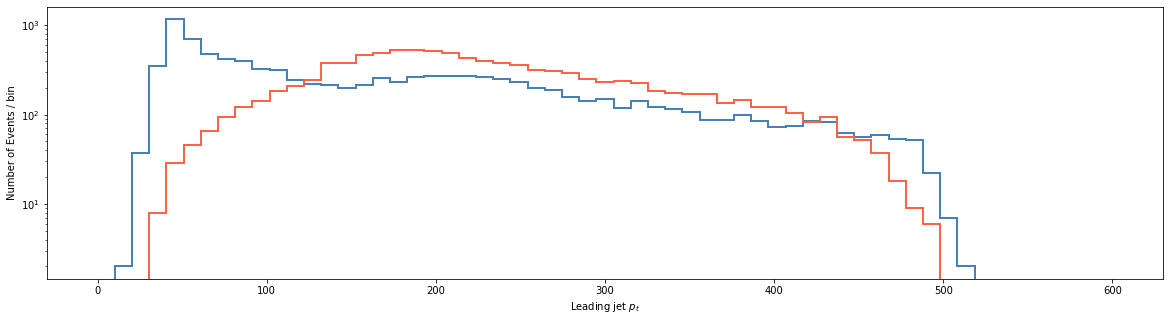

In [10]:
plot_jets(0,1,"Leading jet $p_{t}$",np.linspace(0,600,60),1)

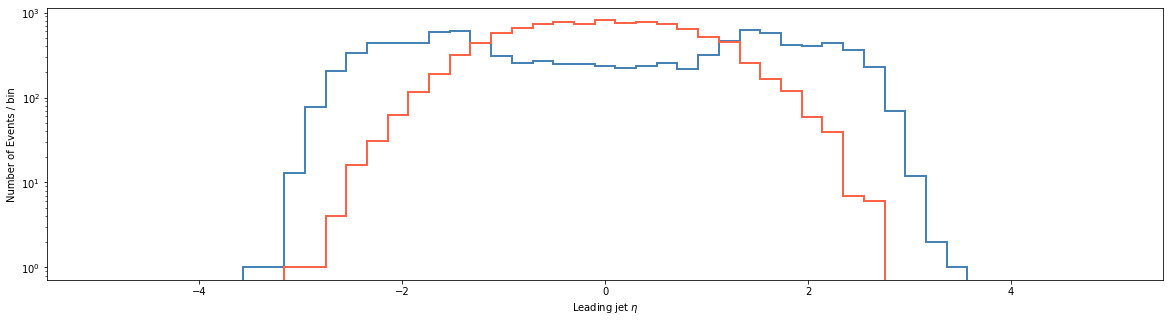

In [11]:
plot_jets(0,2,"Leading jet $\eta$",np.linspace(-5,5,50),1)

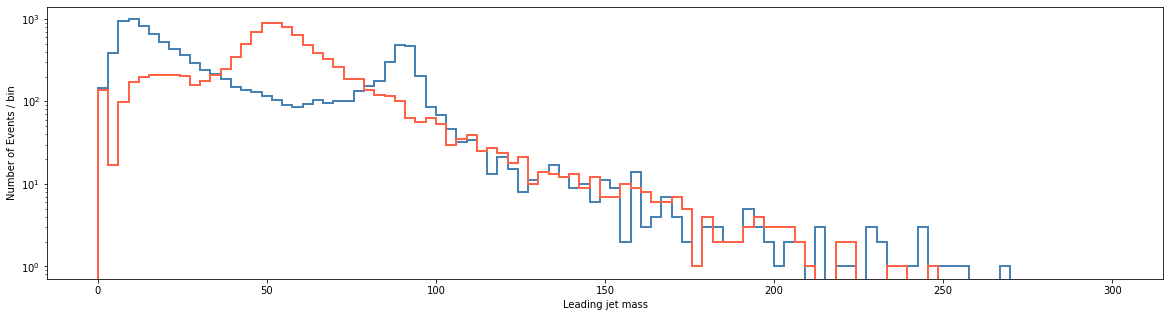

In [12]:
plot_jets(0,4,"Leading jet mass",np.linspace(0,300,100),1)

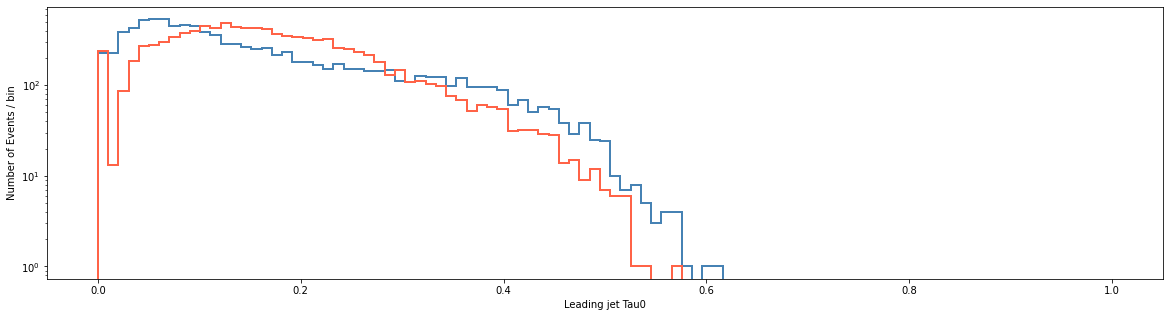

In [13]:
plot_jets(0,6,"Leading jet Tau0",np.linspace(0,1,100),1)

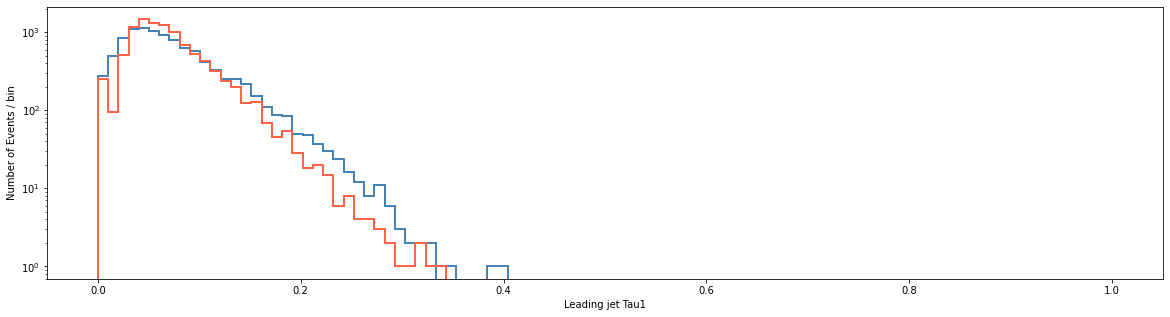

In [14]:
plot_jets(0,7,"Leading jet Tau1",np.linspace(0,1,100),1)

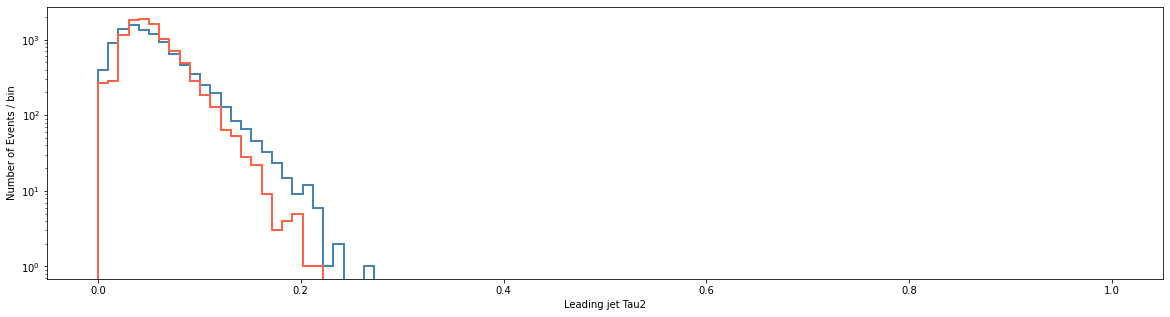

In [15]:
plot_jets(0,8,"Leading jet Tau2",np.linspace(0,1,100),1)

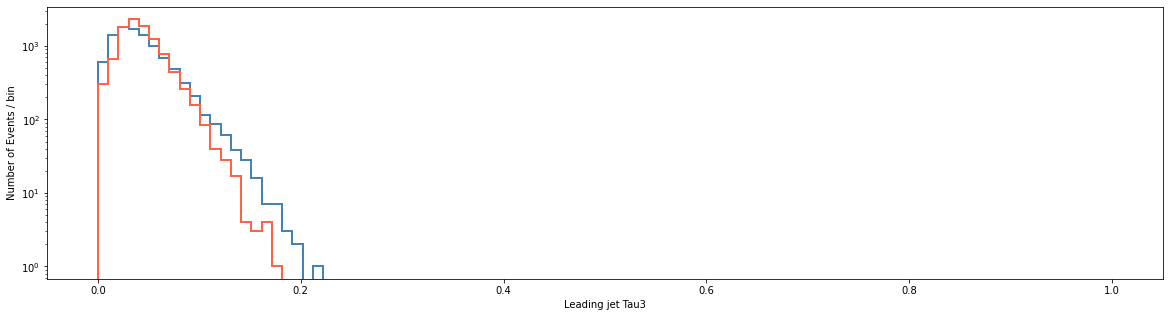

In [16]:
plot_jets(0,9,"Leading jet Tau3",np.linspace(0,1,100),1)

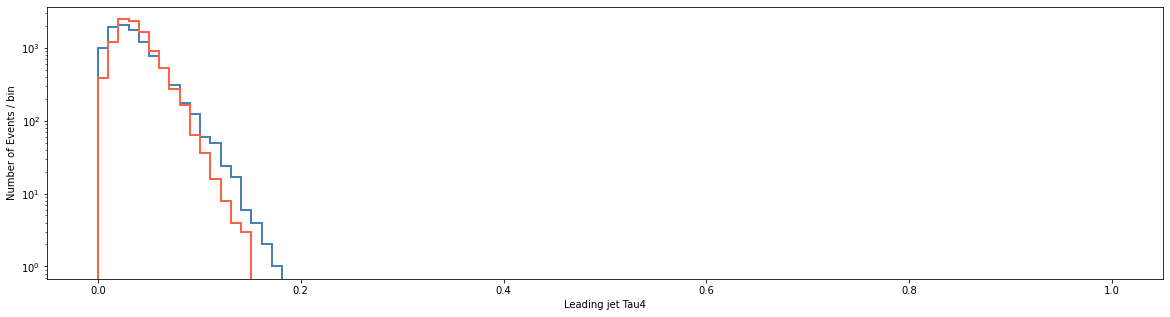

In [17]:
plot_jets(0,10,"Leading jet Tau4",np.linspace(0,1,100),1)

## Features for jets

In [18]:
max_njets = max([i['njets'] for i in all_records])
print(max_njets)

8


In [19]:
padded_jet_arrays =[]
for record in all_records:
    # convert to np array
    these_jets = np.array(record['jets']).astype('float')
    # omit index 0
    if len(these_jets) == 0:
        these_jets = np.zeros(11).reshape([1,11])
    #these_jets = these_jets[:,1:] 
    these_jets = these_jets[:,6:11] # only want nsubjettiness
        
    # determine how many zero values to pad
    pad_length = max_njets - these_jets.shape[0]
    #pad
    padded_jets = np.pad(these_jets, ((0,pad_length),(0,0)))
    # check padding
    #assert padded_jets.shape == (max_njets, 10)
    assert padded_jets.shape == (max_njets, 5)  # only want nsubjettiness
    # add to list
    padded_jet_arrays.append(padded_jets)
    
all_jet_array = np.array(padded_jet_arrays)
X = all_jet_array

In [20]:
X.shape

(89999, 8, 5)

In [21]:
y = np.array([i['truthsqrtshat'] for i in all_records])

In [22]:
side_band_left = 140
side_band_right = 560
signal_left = 340
signal_right = 360
def binary_side_band(y_thing):
    if y_thing >= signal_left and y_thing < signal_right:
        return 1
    elif y_thing >= side_band_left and y_thing < side_band_right:
        return 0
    else:
        return -1

In [23]:
y_binary = np.vectorize(binary_side_band)(y)
np.unique(y_binary,return_counts = True)

(array([-1,  0,  1]), array([68815, 10925, 10259]))

In [24]:
within_bounds_indicator = y_binary >= 0
np.unique(within_bounds_indicator,return_counts = True)

(array([False,  True]), array([68815, 21184]))

In [25]:
X_selected = X[within_bounds_indicator]
y_selected = y_binary[within_bounds_indicator]

In [26]:
X.shape

(89999, 8, 5)

# NN training

In [27]:
from sklearn.utils import shuffle
import energyflow as ef
from energyflow.archs import DNN
from energyflow.utils import data_split, remap_pids, to_categorical
from sklearn.metrics import roc_auc_score, roc_curve

In [28]:
X_shuffled, y_shuffled = shuffle(X_selected, y_selected)
train, val, test = 18000, 2000, 1186

In [29]:
# center and normalize
#X_normalized = np.copy(X_shuffled)
#for x in X_normalized:
#    mask = x[:,0] > 0
    #yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    #x[mask,1:3] -= yphi_avg
#    x[mask,0] /= x[:,0].sum()
#X_normalized = X_normalized[:,:,:3]

In [31]:
def scale_data(data, mean_vector, std_vector):
    return (data - mean_vector) / std_vector

In [32]:
#mean_vector = np.nanmean(X_train, axis=0)
#std_vector = np.nanstd(X_train, axis=0)

#X_normalized = scale_data(X_train, mean_vector, std_vector)
#X_normalized = X_normalized.flatten()

In [33]:
# categorize y
#Y = to_categorical(y_shuffled, num_classes=2)

In [34]:
# do train/val/test split 
#(X_train, X_val, X_test,
# Y_train, Y_val, Y_test) = data_split(X_normalized, Y, val=val, test=test)

### Building the model

In [104]:
# network architecture parameters
dense_sizes = (100, 100)

# network training parameters
num_epoch = 10
batch_size = 100


In [105]:
dnn = DNN(input_dim=5, dense_sizes=dense_sizes, summary=(i==0))

In [106]:
X_train.shape

(17998, 8, 5)

In [107]:
# train model
dnn.fit(X_train, Y_train,
    epochs=num_epoch,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    verbose=1)

Epoch 1/10


ValueError: in user code:

    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/inesochoa/PhysicsWorkdir/fullenv/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 2) and (None, 8, 2) are incompatible
